### aim: Back of envelope calculation of climate feedbacks on DIC.


Steps: 

1) collect inputs to calculation

    1a) input: 50-year trends in SST, MLD, OT due to ozone & GHG under SSP1, SSP3
        
        scratch/SO-wind-feedback/MF-phystrends.ipynb
        
    1b) input: biological, carbonate chemistry, inputs 
        - 1b1: from observations
        - 1b2 from MEDUSA
    
2) calculate 50-year changes in DIC due to SST, MLD, OT using 1a and 1b1 and 1b2

3) profit (make graph and table)
 
### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master')
import mocsy
import gsw

## load physical quantity changes and inputs

In [4]:
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'

input_str = './data/BOE-inputs/BOE-INPUT-MEDUSA.nc'
output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA_conc.nc'

input_str = './data/BOE-inputs/BOE-INPUT-OBS.nc'
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'

## calculate effects of SST, OT, and MLD in umol/L (mmol/m3)

In [5]:
def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio, SO_area, MLD = 100):

    dDIC_OT = ot_delta * 1e6 * grad_DIC_surfdeep / 1000*31557600    ## in mols to surface
    dTA_OT = -(1/3)*dDIC_OT 
    
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dBioDIC_OT = dDICv * ot_delta * 1e6 * 1000*31557600*0.000001 #in mols extra DIC to surface    
    dDIC_OT = dDIC_OT/SO_area/MLD*1000
    dTA_OT = dTA_OT/SO_area/MLD*1000 ## mmols/m3 at surface
    dBioDIC_OT = dBioDIC_OT/SO_area/MLD*1000 ## mmols/m3 at surface
    
    return dDIC_OT, dTA_OT, dBioDIC_OT


In [6]:
ot_delta = 5
grad_DIC_surfdeep = 120
dmudFe = 0.59
grad_dFev = 0.4
mu_L = 1
diatconc = 1
SO_area = 4.67e13
efratio = 0.5
dDIC_OT, dTA_OT, dBioDIC_OT = effect_OT(ot_delta,grad_DIC_surfdeep,\
                                        dmudFe, grad_dFev, mu_L, \
                                         diatconc, efratio, SO_area)

print(dDIC_OT)

4.054509635974304


In [7]:
def effect_SST(R, DIC, pCO2, sst_delta):
    
    dpCO2 = 0.04*pCO2*sst_delta
    delDIC = (DIC/pCO2) * dpCO2/R
    
    #for a positive increase in sst, negative DIC
    delDIC = 1 *delDIC
    return delDIC
    

    
def effect_MLD(mld_delta, grad_dDICdz,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L

    ##ta
    dTA = dDIC * (-1/3)

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio #dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    
    return dDIC, dTA, dDIC_fe


def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio, SO_area, MLD = 100):

    dDIC_OT = ot_delta * 1e6 * grad_DIC_surfdeep / 1000*31557600    ## in mols to surface
    dTA_OT = -(1/3)*dDIC_OT 
    
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dBioDIC_OT = dDICv * ot_delta * 1e6 * 1000*31557600*0.000001 #in mols extra DIC to surface    
    dDIC_OT = dDIC_OT/SO_area/MLD*1000
    dTA_OT = dTA_OT/SO_area/MLD*1000 ## mmols/m3 at surface
    dBioDIC_OT = dBioDIC_OT/SO_area/MLD*1000 ## mmols/m3 at surface
    
    return dDIC_OT, dTA_OT, dBioDIC_OT



def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dDIC_SST = effect_SST(mn_Revfact, mn_DIC, mn_pCO2, sst_delta)
    
    dDIC_MLD, dTA_MLD, dBioDIC_MLD = effect_MLD(mld_delta, grad_dDICdz,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio)
    
    dDIC_OT, dTA_OT, dBioDIC_OT = effect_OT(ot_delta,grad_DIC_surfdeep,\
                                            dmudFe, grad_dFev, mu_L, diatconc, efratio, SO_area)
    
    CO2_SST = dDIC_SST
    CO2_MLD_phys_chem = dDIC_MLD # dTA_MLD +
    CO2_OT_phys_chem = dDIC_OT #+ dTA_OT
    CO2_OT_MLD_bio = dBioDIC_OT + dBioDIC_MLD
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    
    if verbose:
        
        print('individual effects')
        print(f'effect SST DIC umol/L{dDIC_SST}')
        print(f'effect MLD (TA, DIC, Fe) DIC umol/L {dTA_MLD}, {dDIC_MLD}, {dBioDIC_MLD}')
        print(f'effect OT (TA, DIC, Fe) DIC umol/L {dTA_OT}, {dDIC_OT}, {dBioDIC_OT}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

    return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dBioDIC_MLD, dBioDIC_OT, CO2_tot



def make_BOE_output(changes_str, input_str, output_str, verbose = False):
    
    changes = xr.open_dataset(changes_str)
    inputs = xr.open_dataset(input_str)
    savenam = output_str
    print(f'making {savenam}')
    
    datar = np.zeros([3,5,6,2,2])
    sigar = np.zeros([3,5,6,2,2])
    data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
    {'units': '/yr',
    'long_name':''}),
                 'sig':(['period', 'season', 'quantity', 'forcing','scenario'], sigar,
    {'units': '/yr',
    'long_name':''}),
    }
    # define coordinates
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                          'CO2_OT_phys_chem','CO2_MLD_bio',\
                                          'CO2_OT_bio','CO2_tot']),
              'forcing': (['forcing'], ['ghg','ozone']),
              'scenario': (['scenario'], ['ssp1','ssp3']),

             }
    attrs = {'made in':'scratch/BOE-SOcarbon/BOE-concentration-based.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ###constants
    efratio = 0.5
    PgC_mol = 1.2e-14 # pgC/mol
    SO_area = 4.67e13#5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask

    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']
    forcingar = ['ghg','ozone']
    scenarioar = ['ssp1','ssp3']

    for p in periodar:
        tpe = int(p[0:4])
        for s in seasonar:
            for f in forcingar:
                for sc in scenarioar:

                    sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                    mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values*5  # / decade to / 50 yrs  
                    ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  

                    sst_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values # / decade to / 50 yrs  
                    mld_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  
                    ot_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  


                    if verbose:
                        print(f'{p} (starts {tpe}), {s}, {f}, {sc}')
                        print(f'---temp delta {sst_t}, mld delta {mld_t}, ot delta {ot_t}')
                        print(f'---temp sig {sst_sig}, mld sig {mld_sig}, ot sig {ot_sig}')

                    mn_kg = inputs.mn_kg.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_pCO2 = inputs.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dDICdz = inputs.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_Revfact = inputs.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_DIC_surfdeep = inputs.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    diatconc = inputs.diatconc.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFedz = inputs.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFev = inputs.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    dmudFe = inputs.dmudFe.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_DIC = inputs.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mu_L = inputs.mu_L.loc[{'period':p, 'season':s, 'scenario': sc }].values 


                    CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dBioDIC_MLD, dBioDIC_OT, CO2_tot =\
                    give_me_summary(mn_kg,mn_pCO2,sst_t,PgC_mol,SO_area,\
                    mld_t, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_t,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)


                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = CO2_SST
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = dBioDIC_MLD
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = dBioDIC_OT
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = CO2_tot

                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = sst_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = np.min([sst_sig,ot_sig,mld_sig])


            if verbose:
                print()
                print()

    ds.to_netcdf(savenam)
    print('done calculations')
    
    return ds

In [8]:
verbose = False
extract = False

changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'

input_str = './data/BOE-inputs/BOE-INPUT-MEDUSA.nc'
output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA_conc.nc'

if extract:
    pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)
    input_str = './data/BOE-inputs/BOE-INPUT-OBS.nc'
    output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'
    pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

In [9]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

ymins = [-10,-10,-10,-10,-10,-10]
ymaxs = [10,10,10,10,10,10,10]

def make_boe_summary_graph_bothssp_slide(output_str, fnam_str, tssp, valuedesc = '', save = False,\
                                        ymins = [-10,-10,-10,-10,-10,-10],\
                                        ymaxs = [10,10,10,10,10,10,10]):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1
    fig, axs = plt.subplots(2,3, figsize=(13*fact, 8*fact), \
                            facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.5)
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.45; tlw = 2; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,3):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = ['ssp3','ssp3']
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
                        
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                            edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*0,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:

                
                axs[i].bar(ind+tw*0,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                

    
        axs[i].set_xticks([1,3])
        axs[i].set_xlim([0,4])
        if i == 0:
            axs[i].set_xticklabels(['',''])
            axs[i].tick_params(axis="x",direction="in", pad=-15)
        if i != 0:
            axs[i].set_xticklabels(['',''])
        axs[i].set_title(f'{p}')
        axs[0].set_ylabel('$\mu$mol L $^{-1}$')
        axs[i].axhline(y=0, color = 'k')
        
        
    for i in range(0,3):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = ['ssp1','ssp1']
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
                
                axs[i+3].bar(ind,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i+3].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i+3].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i+3].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i+3].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:
                
                axs[i+3].bar(ind+tw*0,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i+3].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i+3].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i+3].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                

    
        axs[i+3].set_xticks([1,3])
        axs[i+3].set_xlim([0,4])
        if i == 0:
            axs[i+3].set_xticklabels(['',''])
            axs[i+3].tick_params(axis="x",direction="in", pad=-15)
        if i != 0:
            axs[i+3].set_xticklabels(['',''])
            
        #axs[i+3].set_title(f'{p} {s}')
        axs[0].set_ylabel('$\mu$mol DIC L$^{-1}$ ')
        axs[i+3].axhline(y=0, color = 'k')
        
        
        
        for i in range(0,3):
            t = 'z'
            if (i%3 == 0):
                t = 'a'
                axs[i+3].set_ylim([-0.3,0.3])
            if (i%3 == 1):
                axs[i+3].set_ylim([-0.2,0.5])
            if (i%3 == 2):
                t = 'c'    
                axs[i].set_ylim([-0.25,2.2])
            axs[i+3].tick_params(axis='x', which='both', length=0.1)
            axs[i].tick_params(axis='x', which='both', length=0.1)
                
    fs = 11
    axs[0].text(2.3+tw*2, 5, 'OT', color = 'r', rotation = 90, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*0, 0.5, 'SST', color = 'b', rotation = 90, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*1, 5, 'MLD', color = 'y', rotation = 90, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*3, 0.5, 'ECO', color = 'g', rotation = 90, fontsize = fs, fontweight = 'bold')
    
    axs[0].text(0.5, 7, '  GHG \n effect', color = 'k', rotation = 0, fontsize = fs+2, fontweight = 'normal')
    axs[0].text(2.5, 7, ' ozone \n effect', color = 'k', rotation = 0, fontsize = fs+2 , fontweight = 'normal')

    for i in range(2):
        for j in range(3):
            print(i*3+j)
            ax = axs[i*3+j]
            if i < 2:  # For the first two rows, position normally
                ax.set_position([0.1 + j*0.5, 0.5 - i*0.25, 0.4, 0.2])
            else:  # For the last two rows, shift downwards to create space
                ax.set_position([0.1 + j*0.5, 0.5 - i*0.25 - 0.1, 0.4, 0.2]) 

        
    for i in range(0,6):
        axs[i].set_ylim([ymins[i],ymaxs[i]])

    fig.text(x = 0.25, y = 0.97, s = 'Ozone and GHG Effects on Surface DIC change, SSP3', fontsize = 20)
    fig.text(x = 0.25, y = 0.4937, s = 'Ozone and GHG Effects on Surface DIC change, SSP1', fontsize = 20)
    fig.subplots_adjust(hspace=0.3) # Adjust the horizontal space

    

In [10]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

ymins = [-10,-10,-10,-10,-10,-10]
ymaxs = [10,10,10,10,10,10,10]

def make_boe_summary_graph_bothssp_slide_withco2(output_str, fnam_str, tssp, valuedesc = '', save = False,\
                                        ymins = [-10,-10,-10,-10,-10,-10],\
                                        ymaxs = [10,10,10,10,10,10,10]):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1
    fig, axs = plt.subplots(2,3, figsize=(13*fact, 8*fact), \
                            facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.5)
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.45; tlw = 2; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,3):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = ['ssp3','ssp3']
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                            edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*0,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                           edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw*0,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
    
        axs[i].set_xticks([1,3])
        
        if i == 0:
            axs[i].set_xticklabels(['',''])
            axs[i].tick_params(axis="x",direction="in", pad=-15)
        if i != 0:
            axs[i].set_xticklabels(['',''])
        axs[i].set_title(f'{p}')
        axs[0].set_ylabel('$\mu$mol L $^{-1}$')
        axs[i].axhline(y=0, color = 'k')
        
    
        
        
    for i in range(0,3):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = ['ssp1','ssp1']
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            

            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
                  
            per = i%3
            p = periodar[per]
            s = seasonar[i]
            fs = ['ghg','ozone',];
            scs = ['ssp1','ssp1']  
                 # f = fs[x]; sc = scs[x]; ind = inds[x]
            print(f'{p}, {s}, {f}, {sc}')
            print(f'CO2 sst {CO2_SST}')
            print(f'CO2 ot {CO2_OT_phys_chem}')
            print(CO2_MLD_phys_chem)
            print(CO2_MLD_bio+CO2_OT_bio)
                  
            ms = 7
            if ind == inds[0]:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                            edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i+3].bar(ind,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i+3].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i+3].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i+3].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i+3].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                           edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i+3].bar(ind+tw*0,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i+3].bar(ind+tw*2,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i+3].bar(ind+tw*1,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i+3].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                

    
        axs[i+3].set_xticks([1,3])
        axs[i+3].set_xlim([0,4])
        if i == 0:
            axs[i+3].set_xticklabels(['',''])
            axs[i+3].tick_params(axis="x",direction="in", pad=-15)
        if i != 0:
            axs[i+3].set_xticklabels(['',''])
            
        #axs[i+3].set_title(f'{p} {s}')
        axs[0].set_ylabel('$\mu$mol DIC L$^{-1}$ ')
        axs[i+3].axhline(y=0, color = 'k')
        
        
        
        for i in range(0,3):
            t = 'z'
            if (i%3 == 0):
                t = 'a'
                axs[i+3].set_ylim([-0.3,0.3])
            if (i%3 == 1):
                axs[i+3].set_ylim([-0.2,0.5])
            if (i%3 == 2):
                t = 'c'    
                #axs[i+3].set_ylim([-0.15,0.15])
                #if tssp == 'ssp3':
                axs[i].set_ylim([-0.25,2.2])
            axs[i+3].tick_params(axis='x', which='both', length=0.1)
            axs[i].tick_params(axis='x', which='both', length=0.1)
                
    fs = 11
#     axs[0].text(2.6, 0.05, 'total', color = 'k', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*2, 6, 'OT', color = 'r', rotation = 90, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*0, 6, 'SST', color = 'b', rotation = 90, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*1, 6, 'MLD', color = 'y', rotation = 90, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.3+tw*3, 6, 'ECO', color = 'g', rotation = 90, fontsize = fs, fontweight = 'bold')
    
    axs[0].text(0.5, 37, '  GHG \n effect', color = 'k', rotation = 0, fontsize = fs+2, fontweight = 'normal')
    axs[0].text(2.5, 37, ' ozone \n effect', color = 'k', rotation = 0, fontsize = fs+2 , fontweight = 'normal')

    for i in range(2):
        for j in range(3):
            print(i*3+j)
            ax = axs[i*3+j]
            if i < 2:  # For the first two rows, position normally
                ax.set_position([0.1 + j*0.5, 0.5 - i*0.25, 0.4, 0.2])
            else:  # For the last two rows, shift downwards to create space
                ax.set_position([0.1 + j*0.5, 0.5 - i*0.25 - 0.1, 0.4, 0.2]) 

        
    for i in range(0,6):
        tdic = [20,42,50,20,25,-10]
        axs[i].set_ylim([-11,52])
        axs[i].set_xlim([-0.4,4])
        axs[i].bar(-0,tdic[i],width = tw, color = 'k', alpha = 1, \
                        edgecolor = 'k', 
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   

    fig.text(x = 0.25, y = 0.97, s = 'Ozone and GHG Effects on Surface DIC change, SSP3', fontsize = 20)
    fig.text(x = 0.25, y = 0.4937, s = 'Ozone and GHG Effects on Surface DIC change, SSP1', fontsize = 20)
    fig.subplots_adjust(hspace=0.3) # Adjust the horizontal space

#     if save:
#         print(f'saved figure at {fnam_str}')
#         plt.savefig(fnam_str)
    

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0
1
2
3
4
5


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


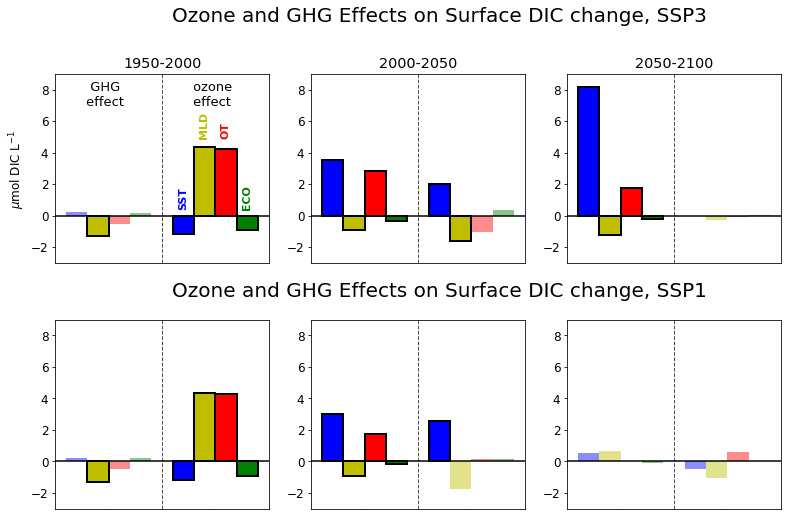

In [11]:
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'
valuedesc = 'CLQ-test'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-OBS_conc.jpg'

ymins = [-3,-3,-3,-3,-3,-3]
ymaxs = [9,9,9,9,9,9]

fig = make_boe_summary_graph_bothssp_slide(output_str, \
                                           fnam_str, tssp, valuedesc,  True, ymins, ymaxs)

## here is with CO2 for comparison
co2 = False
if co2:
    
    fig = make_boe_summary_graph_bothssp_slide_withco2(output_str, \
                                               fnam_str, tssp, valuedesc,  True, ymins, ymaxs)

0
1
2
3
4
5


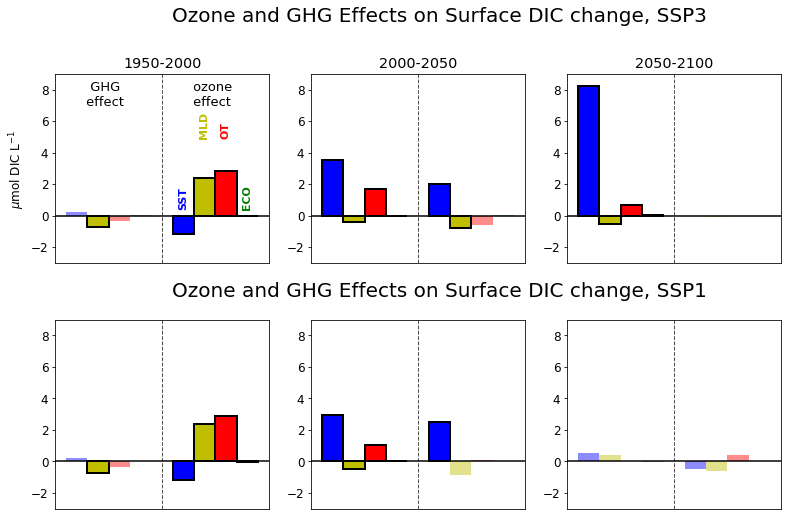

In [12]:
output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA_conc.nc'
valuedesc = 'CLQ-test'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-MEDUSA_conc.jpg'

ymins = [-3,-3,-3,-3,-3,-3]
ymaxs = [9,9,9,9,9,9]

fig = make_boe_summary_graph_bothssp_slide(output_str, \
                                           fnam_str, tssp, valuedesc,  True, ymins, ymaxs)


ozone
1950-2000
ghg
1950-2000
ozone
1950-2000
ghg
1950-2000
ozone
2000-2050
ghg
2000-2050
ozone
2000-2050
ghg
2000-2050
ozone
2050-2100
ghg
2050-2100
ozone
2050-2100
ghg
2050-2100


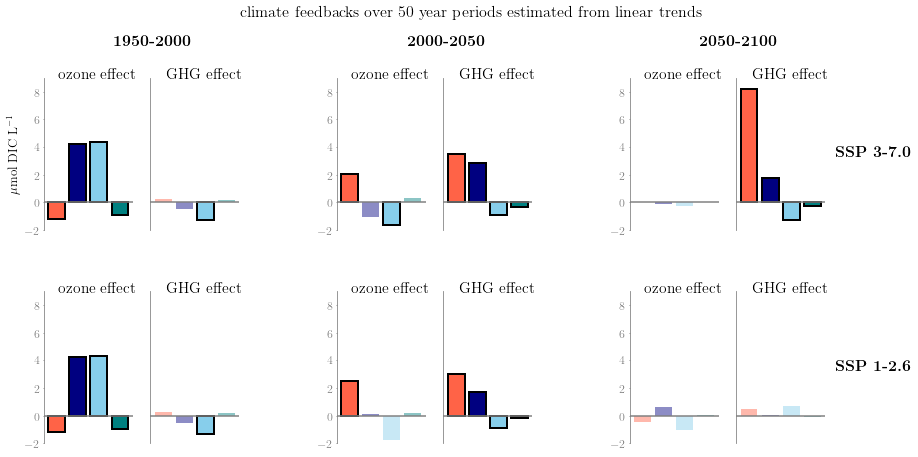

In [78]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'
ds = xr.open_dataset(output_str)

ty = 0.95
tx = 0.6

sstcol = 'tomato'#'#e6194B'#'r'
otcol = 'navy'#'#9A6324'#'#37323d'#'#2c3438'
mldcol = 'skyblue'#'#4363d8'#'b'#'#34abeb'
ecocol = 'teal'#'#66b54c'#'#5f8a1e'
tlw = 2; lowsigalpha = 0.45; lowsiglw = 0


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
verbose = False
tw = 1.2; marg = 0.3; biggap = 0.6; smolgap = 0.3

ocol = '#42d4f4'
ghgcol = 'dimgrey'
warmssp1col = ghgcol# 'lightskyblue' #'lightgrey''dimgrey', 'silver' 
warmssp3col = ghgcol #'mediumblue' #'dimgrey'
ozssp1col = ocol
ozssp3col = ocol

tplac = 1


# Create the main figure
fig = plt.figure(figsize=(14, 7))

# Define GridSpec for the 4 main subplots
outer_grid = gridspec.GridSpec(2, 3, fig, wspace=0.5, hspace = 0.4)

periodar = ['1950-2000','2000-2050','2050-2100']
seasonar = ['FY','FY','FY',\
            'DJF','DJF','DJF',\
            'MAM', 'MAM', 'MAM',\
            'JJA','JJA','JJA',\
            'SON','SON','SON']
quantityar = ['ozone \n effect','sst','mld','ot']
quantityart = ['ozone effect','GHG effect','MLD (m)','OT (Sv)']
quantmins = [-2 ,-2  ,-3*5 ,-2.2*5 ]

quantmaxs = [9,9,3*5 ,2.2*5 ]

# Loop to create each of the 4 main subplots
for i in range(3): #15
    
    per = i%3
    tperiod = periodar[per]
    tseas = seasonar[i]
    if verbose:
        print('')
        print(f'{tperiod}, {tseas}')
    
    # Create a subplot in the outer grid
    outer_ax = plt.Subplot(fig, outer_grid[i])
    fig.add_subplot(outer_ax)
    outer_ax.set_yticks([])
    outer_ax.set_xticks([])
    outer_ax.spines['right'].set_visible(False)
    outer_ax.spines['bottom'].set_visible(False)
    outer_ax.spines['top'].set_visible(False)
    outer_ax.spines['left'].set_visible(False)

#     # Define GridSpec for the 3 nested subplots inside the current main subplot


#     # Define GridSpec for the 3 nested subplots inside the current main subplot
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.2)

    fs = ['ozone','ghg',]
    for j in range(2):
        f = fs[j]; sc = 'ssp3'; s = 'FY'; p = tperiod
        print(f)
        print(p)
        tquantity = quantityar[j]
        tquantityt = quantityart[j]
        # Create a subplot in the inner grid
        inner_ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(inner_ax)
        
        inner_ax.set_title(tquantityt, fontweight = 'normal', y = ty, x = tx)
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ##### significances
        CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 

        CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
        CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
        CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1

        CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
        CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
        CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw


        if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
        if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
        if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha

        if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
        if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
        if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
        
        tplac = 1
        inner_ax.bar(tplac,CO2_SST,width = tw, color = sstcol, \
                    alpha = CO2_SST_alpha, edgecolor = 'k', lw = CO2_SST_lw, label ='SST')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_phys_chem, width = tw, color = otcol,\
                    alpha = CO2_OT_phys_chem_alpha, edgecolor = 'k', lw = CO2_OT_phys_chem_lw, label = 'MOC')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_MLD_phys_chem, width = tw, color = mldcol,\
                    alpha = CO2_MLD_phys_chem_alpha, edgecolor = 'k', lw = CO2_MLD_phys_chem_lw, label = 'MLD')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_bio+CO2_MLD_bio, width = tw, color = ecocol,\
                    alpha = CO2_bio_alpha, edgecolor = 'k', lw = CO2_bio_lw, label = 'ECO')
        
        inner_ax.set_ylim([quantmins[j],quantmaxs[j]])
        inner_ax.set_xlim([1-(tw/2)-marg,tplac+(tw/2)+marg])
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['bottom'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        inner_ax.spines['left'].set_color('grey')
        inner_ax.axhline(y=0, color = 'grey')
        inner_ax.set_xticks([])
        if j == 1:
            inner_ax.set_yticks([])
        if (j == 0) & (i == 0):
            inner_ax.set_ylabel('$\mu$mol DIC L$^{-1}$')
        inner_ax.tick_params(axis='y', colors='grey')
        inner_ax.tick_params(labelsize = 12, length = 1, color = 'grey')
        

    ### ssp1
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i+3], wspace=0.2)

    fs = ['ozone','ghg',]
    for j in range(2):
        f = fs[j]; sc = 'ssp1'; s = 'FY'; p = tperiod
        print(f)
        print(p)
        tquantity = quantityar[j]
        tquantityt = quantityart[j]
        # Create a subplot in the inner grid
        inner_ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(inner_ax)
        
        inner_ax.set_title(tquantityt, fontweight = 'normal', y = ty, x = tx)
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ##### significances
        CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 

        CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
        CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
        CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1

        CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
        CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
        CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw


        if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
        if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
        if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha

        if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
        if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
        if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
        
        tplac = 1
        inner_ax.bar(tplac,CO2_SST,width = tw, color = sstcol, \
                    alpha = CO2_SST_alpha, edgecolor = 'k', lw = CO2_SST_lw)
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_phys_chem, width = tw, color = otcol,\
                    alpha = CO2_OT_phys_chem_alpha, edgecolor = 'k', lw = CO2_OT_phys_chem_lw)
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_MLD_phys_chem, width = tw, color = mldcol,\
                    alpha = CO2_MLD_phys_chem_alpha, edgecolor = 'k', lw = CO2_MLD_phys_chem_lw)
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_bio+CO2_MLD_bio, width = tw, color = ecocol,\
                    alpha = CO2_bio_alpha, edgecolor = 'k', lw = CO2_bio_lw)
        
        inner_ax.set_ylim([quantmins[j],quantmaxs[j]])
        inner_ax.set_xlim([1-(tw/2)-marg,tplac+(tw/2)+marg])
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['bottom'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        inner_ax.spines['left'].set_color('grey')
        inner_ax.axhline(y=0, color = 'grey')
        inner_ax.set_xticks([])
        if j == 1:
            inner_ax.set_yticks([])
        inner_ax.tick_params(axis='y', colors='grey')
        inner_ax.tick_params(labelsize = 12, length = 1, color = 'grey')
    
    
fl = 0.915; fs = 16
fig.text(y = fl, x = 0.195, s = r'\textbf{1950-2000}', fontsize = fs, fontweight = 'bold')
fig.text(y = fl, x = 0.485, s = r'\textbf{2000-2050}', fontsize = fs, fontweight = 'bold')
fig.text(y = fl, x = 0.775, s = r'\textbf{2050-2100}', fontsize = fs, fontweight = 'bold')
tle = 0.06

# fig.text(y = 0.495, x = 0.26, s = 'changes over 50 years estimated from linear trends, SSP1',\
#          fontsize = 16, color = 'k', fontweight = 'normal')
fig.text(y = 0.97, x = 0.32, s = 'climate feedbacks over 50 year periods estimated from linear trends',\
         fontsize = fs, color = 'k', fontweight = 'normal')

fig.text(y = 0.694, x = 0.91, s = r'\textbf{SSP 3-7.0}',\
         fontsize = fs, color = 'k', fontweight = 'normal')

fig.text(y = 0.27, x = 0.91, s = r'\textbf{SSP 1-2.6}',\
         fontsize = fs, color = 'k', fontweight = 'normal')


plt.tight_layout()

metadata = {
    'Description': 'scratch/SOZONE/windAnalyis/oceanFields/bargraph-with-50yrtrends.ipynb'
}
fig.subplots_adjust(top=0.85) 

# plt.savefig('./figs/MF-50yrtrends.png', dpi = 300, metadata = metadata)


fig.savefig('./figs/MF-50yrtrends.png', transparent=None, dpi=250, format=None,
        metadata=None, bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,
       )
plt.show()

ozone
1950-2000


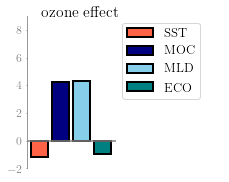

In [77]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'
ds = xr.open_dataset(output_str)

ty = 0.95
tx = 0.6

sstcol = 'tomato'#'#e6194B'#'r'
otcol = 'navy'#'#9A6324'#'#37323d'#'#2c3438'
mldcol = 'skyblue'#'#4363d8'#'b'#'#34abeb'
ecocol = 'teal'#'#66b54c'#'#5f8a1e'
tlw = 2; lowsigalpha = 0.45; lowsiglw = 0


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
verbose = False
tw = 1.2; marg = 0.3; biggap = 0.6; smolgap = 0.3

ocol = '#42d4f4'
ghgcol = 'dimgrey'
warmssp1col = ghgcol# 'lightskyblue' #'lightgrey''dimgrey', 'silver' 
warmssp3col = ghgcol #'mediumblue' #'dimgrey'
ozssp1col = ocol
ozssp3col = ocol

tplac = 1


# Create the main figure
fig = plt.figure(figsize=(14, 7))

# Define GridSpec for the 4 main subplots
outer_grid = gridspec.GridSpec(2, 3, fig, wspace=0.5, hspace = 0.4)

periodar = ['1950-2000','2000-2050','2050-2100']
seasonar = ['FY','FY','FY',\
            'DJF','DJF','DJF',\
            'MAM', 'MAM', 'MAM',\
            'JJA','JJA','JJA',\
            'SON','SON','SON']
quantityar = ['ozone \n effect','sst','mld','ot']
quantityart = ['ozone effect','GHG effect','MLD (m)','OT (Sv)']
quantmins = [-2 ,-2  ,-3*5 ,-2.2*5 ]

quantmaxs = [9,9,3*5 ,2.2*5 ]

# Loop to create each of the 4 main subplots
for i in range(1): #15
    
    per = i%3
    tperiod = periodar[per]
    tseas = seasonar[i]
    if verbose:
        print('')
        print(f'{tperiod}, {tseas}')
    
    # Create a subplot in the outer grid
    outer_ax = plt.Subplot(fig, outer_grid[i])
    fig.add_subplot(outer_ax)
    outer_ax.set_yticks([])
    outer_ax.set_xticks([])
    outer_ax.spines['right'].set_visible(False)
    outer_ax.spines['bottom'].set_visible(False)
    outer_ax.spines['top'].set_visible(False)
    outer_ax.spines['left'].set_visible(False)

#     # Define GridSpec for the 3 nested subplots inside the current main subplot


#     # Define GridSpec for the 3 nested subplots inside the current main subplot
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.2)

    fs = ['ozone','ozone',]
    for j in range(1):
        f = fs[j]; sc = 'ssp3'; s = 'FY'; p = tperiod
        print(f)
        print(p)
        tquantity = quantityar[j]
        tquantityt = quantityart[j]
        # Create a subplot in the inner grid
        inner_ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(inner_ax)
        
        inner_ax.set_title(tquantityt, fontweight = 'normal', y = ty, x = tx)
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ##### significances
        CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 

        CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
        CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
        CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1

        CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
        CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
        CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw


        if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
        if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
        if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha

        if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
        if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
        if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
        
        tplac = 1
        inner_ax.bar(tplac,CO2_SST,width = tw, color = sstcol, \
                    alpha = CO2_SST_alpha, edgecolor = 'k', lw = CO2_SST_lw, label ='SST')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_phys_chem, width = tw, color = otcol,\
                    alpha = CO2_OT_phys_chem_alpha, edgecolor = 'k', lw = CO2_OT_phys_chem_lw, label = 'MOC')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_MLD_phys_chem, width = tw, color = mldcol,\
                    alpha = CO2_MLD_phys_chem_alpha, edgecolor = 'k', lw = CO2_MLD_phys_chem_lw, label = 'MLD')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_bio+CO2_MLD_bio, width = tw, color = ecocol,\
                    alpha = CO2_bio_alpha, edgecolor = 'k', lw = CO2_bio_lw, label = 'ECO')
        
        inner_ax.set_ylim([quantmins[j],quantmaxs[j]])
        inner_ax.set_xlim([1-(tw/2)-marg,tplac+(tw/2)+marg])
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['bottom'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        inner_ax.spines['left'].set_color('grey')
        inner_ax.axhline(y=0, color = 'grey')
        inner_ax.set_xticks([])
        if j == 1:
            inner_ax.set_yticks([])
        inner_ax.tick_params(axis='y', colors='grey')
        inner_ax.tick_params(labelsize = 12, length = 1, color = 'grey')
        
        inner_ax.legend(bbox_to_anchor = [1,1])
    ### ssp1
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i+3], wspace=0.2)



plt.tight_layout()

metadata = {
    'Description': 'scratch/SOZONE/windAnalyis/oceanFields/bargraph-with-50yrtrends.ipynb'
}
fig.subplots_adjust(top=0.85) 

# plt.savefig('./figs/MF-50yrtrends.png', dpi = 300, metadata = metadata)


fig.savefig('./figs/MF-50yrtrendslegend.png', transparent=None, dpi=250, format=None,
        metadata=None, bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,
       )
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'
ds = xr.open_dataset(output_str)

ty = 0.95
tx = 0.6

sstcol = 'tomato'#'#e6194B'#'r'
otcol = 'navy'#'#9A6324'#'#37323d'#'#2c3438'
mldcol = 'skyblue'#'#4363d8'#'b'#'#34abeb'
ecocol = 'teal'#'#66b54c'#'#5f8a1e'
tlw = 2; lowsigalpha = 0.45; lowsiglw = 0


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
verbose = False
tw = 1.2; marg = 0.3; biggap = 0.6; smolgap = 0.3

ocol = '#42d4f4'
ghgcol = 'dimgrey'
warmssp1col = ghgcol# 'lightskyblue' #'lightgrey''dimgrey', 'silver' 
warmssp3col = ghgcol #'mediumblue' #'dimgrey'
ozssp1col = ocol
ozssp3col = ocol

tplac = 1


# Create the main figure
fig = plt.figure(figsize=(14, 7))

# Define GridSpec for the 4 main subplots
outer_grid = gridspec.GridSpec(2, 3, fig, wspace=0.5, hspace = 0.4)

periodar = ['1950-2000','2000-2050','2050-2100']
seasonar = ['FY','FY','FY',\
            'DJF','DJF','DJF',\
            'MAM', 'MAM', 'MAM',\
            'JJA','JJA','JJA',\
            'SON','SON','SON']
quantityar = ['ozone \n effect','sst','mld','ot']
quantityart = ['ozone effect','GHG effect','MLD (m)','OT (Sv)']
quantmins = [-2 ,-2  ,-3*5 ,-2.2*5 ]

quantmaxs = [9,9,3*5 ,2.2*5 ]

# Loop to create each of the 4 main subplots
for i in range(3): #15
    
    per = i%3
    tperiod = periodar[per]
    tseas = seasonar[i]
    if verbose:
        print('')
        print(f'{tperiod}, {tseas}')
    
    # Create a subplot in the outer grid
    outer_ax = plt.Subplot(fig, outer_grid[i])
    fig.add_subplot(outer_ax)
    outer_ax.set_yticks([])
    outer_ax.set_xticks([])
    outer_ax.spines['right'].set_visible(False)
    outer_ax.spines['bottom'].set_visible(False)
    outer_ax.spines['top'].set_visible(False)
    outer_ax.spines['left'].set_visible(False)

#     # Define GridSpec for the 3 nested subplots inside the current main subplot


#     # Define GridSpec for the 3 nested subplots inside the current main subplot
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.2)

    fs = ['ozone','ghg',]
    for j in range(2):
        f = fs[j]; sc = 'ssp3'; s = 'FY'; p = tperiod
        print(f)
        print(p)
        tquantity = quantityar[j]
        tquantityt = quantityart[j]
        # Create a subplot in the inner grid
        inner_ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(inner_ax)
        
        inner_ax.set_title(tquantityt, fontweight = 'normal', y = ty, x = tx)
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ##### significances
        CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 

        CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
        CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
        CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1

        CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
        CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
        CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw


        if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
        if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
        if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha

        if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
        if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
        if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
        
        tplac = 1
        inner_ax.bar(tplac,CO2_SST,width = tw, color = sstcol, \
                    alpha = CO2_SST_alpha, edgecolor = 'k', lw = CO2_SST_lw, label ='SST')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_phys_chem, width = tw, color = otcol,\
                    alpha = CO2_OT_phys_chem_alpha, edgecolor = 'k', lw = CO2_OT_phys_chem_lw, label = 'MOC')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_MLD_phys_chem, width = tw, color = mldcol,\
                    alpha = CO2_MLD_phys_chem_alpha, edgecolor = 'k', lw = CO2_MLD_phys_chem_lw, label = 'MLD')
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_bio+CO2_MLD_bio, width = tw, color = ecocol,\
                    alpha = CO2_bio_alpha, edgecolor = 'k', lw = CO2_bio_lw, label = 'ECO')
        
        inner_ax.set_ylim([quantmins[j],quantmaxs[j]])
        inner_ax.set_xlim([1-(tw/2)-marg,tplac+(tw/2)+marg])
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['bottom'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        inner_ax.spines['left'].set_color('grey')
        inner_ax.axhline(y=0, color = 'grey')
        inner_ax.set_xticks([])
        if j == 1:
            inner_ax.set_yticks([])
        inner_ax.tick_params(axis='y', colors='grey')
        inner_ax.tick_params(labelsize = 12, length = 1, color = 'grey')
        

    ### ssp1
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i+3], wspace=0.2)

    fs = ['ozone','ghg',]
    for j in range(2):
        f = fs[j]; sc = 'ssp1'; s = 'FY'; p = tperiod
        print(f)
        print(p)
        tquantity = quantityar[j]
        tquantityt = quantityart[j]
        # Create a subplot in the inner grid
        inner_ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(inner_ax)
        
        inner_ax.set_title(tquantityt, fontweight = 'normal', y = ty, x = tx)
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ##### significances
        CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]

        CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 

        CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 

        CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]

        CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 

        CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
        CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
        CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1

        CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
        CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
        CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw


        if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
        if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
        if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha

        if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
        if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
        if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
        if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
        if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
        if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
        
        tplac = 1
        inner_ax.bar(tplac,CO2_SST,width = tw, color = sstcol, \
                    alpha = CO2_SST_alpha, edgecolor = 'k', lw = CO2_SST_lw)
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_phys_chem, width = tw, color = otcol,\
                    alpha = CO2_OT_phys_chem_alpha, edgecolor = 'k', lw = CO2_OT_phys_chem_lw)
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_MLD_phys_chem, width = tw, color = mldcol,\
                    alpha = CO2_MLD_phys_chem_alpha, edgecolor = 'k', lw = CO2_MLD_phys_chem_lw)
        tplac = tplac+tw+smolgap
        inner_ax.bar(tplac,CO2_OT_bio+CO2_MLD_bio, width = tw, color = ecocol,\
                    alpha = CO2_bio_alpha, edgecolor = 'k', lw = CO2_bio_lw)
        
        inner_ax.set_ylim([quantmins[j],quantmaxs[j]])
        inner_ax.set_xlim([1-(tw/2)-marg,tplac+(tw/2)+marg])
        inner_ax.spines['top'].set_visible(False)
        inner_ax.spines['bottom'].set_visible(False)
        inner_ax.spines['right'].set_visible(False)
        inner_ax.spines['left'].set_color('grey')
        inner_ax.axhline(y=0, color = 'grey')
        inner_ax.set_xticks([])
        if j == 1:
            inner_ax.set_yticks([])
        inner_ax.tick_params(axis='y', colors='grey')
        inner_ax.tick_params(labelsize = 12, length = 1, color = 'grey')
    
    
fl = 0.915; fs = 16
fig.text(y = fl, x = 0.195, s = r'\textbf{1950-2000}', fontsize = fs, fontweight = 'bold')
fig.text(y = fl, x = 0.485, s = r'\textbf{2000-2050}', fontsize = fs, fontweight = 'bold')
fig.text(y = fl, x = 0.775, s = r'\textbf{2050-2100}', fontsize = fs, fontweight = 'bold')
tle = 0.06

# fig.text(y = 0.495, x = 0.26, s = 'changes over 50 years estimated from linear trends, SSP1',\
#          fontsize = 16, color = 'k', fontweight = 'normal')
fig.text(y = 0.97, x = 0.32, s = 'climate feedbacks over 50 year periods estimated from linear trends',\
         fontsize = fs, color = 'k', fontweight = 'normal')

fig.text(y = 0.694, x = 0.91, s = r'\textbf{SSP 3-7.0}',\
         fontsize = fs, color = 'k', fontweight = 'normal')

fig.text(y = 0.27, x = 0.91, s = r'\textbf{SSP 1-2.6}',\
         fontsize = fs, color = 'k', fontweight = 'normal')


plt.tight_layout()

metadata = {
    'Description': 'scratch/SOZONE/windAnalyis/oceanFields/bargraph-with-50yrtrends.ipynb'
}
fig.subplots_adjust(top=0.85) 

# plt.savefig('./figs/MF-50yrtrends.png', dpi = 300, metadata = metadata)

plt.show()

## What is the change in surface DIC from medusa over this time period?

In [13]:
def make_yearlist(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])

    return ylist

ylist = make_yearlist(1950, 2099, '1A')
tds_1A = xr.open_mfdataset(ylist)
ylist = make_yearlist(1950, 2099, '1B')
tds_1B = xr.open_mfdataset(ylist)


In [14]:
tds_1A

<xarray.Dataset>
Dimensions:            (quantity: 4, time_counter: 1800)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 1950-01-01 ... 2099-12-01
  * quantity           (quantity) object 'mean' 'stdev' 'max' 'min'
Data variables:
    grad_dDICdz        (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    grad_DIC_surfdeep  (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_kg              (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_SST             (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_Revfact         (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_DIC             (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_TA              (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_pCO2            (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
Attributes:
    made in:  scratch/BOE-SOcarbon/extract_BOE_parameters_from_MEDUSA.py
    desc:

In [15]:
def make_yearlistsdp(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylistsdp = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-glodap_sdp_scen-{scen}-{yr}.nc')
        ylistsdp.append(t2[0])

    return ylistsdp

ylistsdp = make_yearlistsdp(1950, 2099, '1A')
tdssdp_1A = xr.open_mfdataset(ylistsdp)
ylistsdp = make_yearlistsdp(1950, 2099, '1B')
tdssdp_1B = xr.open_mfdataset(ylistsdp)





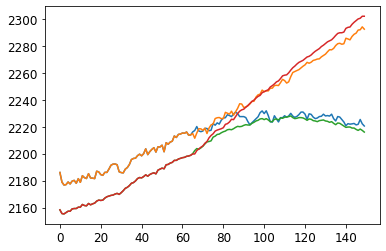

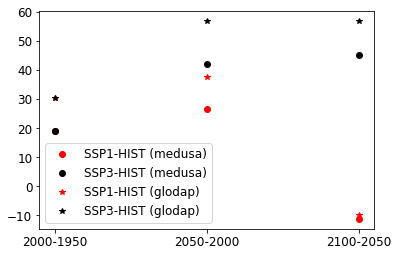

In [16]:
tDIC_1A = tds_1A.mn_DIC.groupby('time_counter.year').mean()[:,0]
plt.plot(tDIC_1A)
tDIC_1B = tds_1B.mn_DIC.groupby('time_counter.year').mean()[:,0]
plt.plot(tDIC_1B)

tDICsdp_1A = tdssdp_1A.mn_DIC.groupby('time_counter.year').mean()[:,0]
plt.plot(tDICsdp_1A)
tDICsdp_1B = tdssdp_1B.mn_DIC.groupby('time_counter.year').mean()[:,0]
plt.plot(tDICsdp_1B)

fig = plt.figure()

plt.plot(1950,tDIC_1A[49]-tDIC_1A[0],'ro', label = 'SSP1-HIST (medusa)')
plt.plot(2000,tDIC_1A[99]-tDIC_1A[49],'ro', )
plt.plot(2050,tDIC_1A[149]-tDIC_1A[99],'ro', )
plt.plot(1950,tDIC_1B[49]-tDIC_1B[0],'ko', label = 'SSP3-HIST (medusa)')
plt.plot(2000,tDIC_1B[99]-tDIC_1B[49],'ko', )
plt.plot(2050,tDIC_1B[149]-tDIC_1B[99],'ko', )

plt.plot(1950,tDICsdp_1A[49]-tDICsdp_1A[0],'r*', label = 'SSP1-HIST (glodap)')
plt.plot(2000,tDICsdp_1A[99]-tDICsdp_1A[49],'r*', )
plt.plot(2050,tDICsdp_1A[149]-tDICsdp_1A[99],'r*', )
plt.plot(1950,tDICsdp_1B[49]-tDICsdp_1B[0],'k*', label = 'SSP3-HIST (glodap)')
plt.plot(2000,tDICsdp_1B[99]-tDICsdp_1B[49],'k*',)
plt.plot(2050,tDICsdp_1B[149]-tDICsdp_1B[99],'k*',)

plt.xticks([1950,2000,2050],['2000-1950','2050-2000','2100-2050'])
# plt.xticklabels()
plt.legend()

In [17]:
print('1A (SSP1)')
per = '1950-2000'
change = np.mean(tDIC_1A.sel(year = slice(1995,2004)).values)\
- np.mean(tDIC_1A.sel(year = slice(1950,1954)).values)
print(f'{per}, range-based {change}')

change = np.mean(tDIC_1A.sel(year = 2000).values)\
- np.mean(tDIC_1A.sel(year = 1950).values)
print(f'{per}, point-based {change}')
print('')
per = '2000-2050'
change = np.mean(tDIC_1A.sel(year = slice(2045,2054)).values)\
- np.mean(tDIC_1A.sel(year = slice(1995,2004)).values)
print(f'{per}, range-based {change}')

change = np.mean(tDIC_1A.sel(year = 2050).values)\
- np.mean(tDIC_1A.sel(year = 2000).values)
print(f'{per}, point-based {change}')
print('')
per = '2050-2100'
change = np.mean(tDIC_1A.sel(year = slice(2095,2100)).values)\
- np.mean(tDIC_1A.sel(year = slice(2045,2054)).values)
print(f'{per}, range-based {change}')

change = np.mean(tDIC_1A.sel(year = 2099).values)\
- np.mean(tDIC_1A.sel(year = 2050).values)
print(f'{per}, point-based {change}')

print('----')
print('1B (SSP3)')
per = '1950-2000'
change = np.mean(tDIC_1B.sel(year = slice(1995,2004)).values)\
- np.mean(tDIC_1B.sel(year = slice(1950,1954)).values)
print(f'{per}, range-based {change}')

change = np.mean(tDIC_1B.sel(year = 2000).values)\
- np.mean(tDIC_1B.sel(year = 1950).values)
print(f'{per}, point-based {change}')
print('')
per = '2000-2050'
change = np.mean(tDIC_1B.sel(year = slice(2045,2054)).values)\
- np.mean(tDIC_1B.sel(year = slice(1995,2004)).values)
print(f'{per}, range-based {change}')

change = np.mean(tDIC_1B.sel(year = 2050).values)\
- np.mean(tDIC_1B.sel(year = 2000).values)
print(f'{per}, point-based {change}')
print('')
per = '2050-2100'
change = np.mean(tDIC_1B.sel(year = slice(2095,2100)).values)\
- np.mean(tDIC_1B.sel(year = slice(2045,2054)).values)
print(f'{per}, range-based {change}')

change = np.mean(tDIC_1B.sel(year = 2099).values)\
- np.mean(tDIC_1B.sel(year = 2050).values)
print(f'{per}, point-based {change}')

1A (SSP1)
1950-2000, range-based 25.509814873396408
1950-2000, point-based 20.276910452659195

2000-2050, range-based 22.654347954549394
2000-2050, point-based 23.433525254946744

2050-2100, range-based -5.438044489867025
2050-2100, point-based -9.20314215426788
----
1B (SSP3)
1950-2000, range-based 25.509814873396408
1950-2000, point-based 20.276910452659195

2000-2050, range-based 40.213208821961416
2000-2050, point-based 39.689457508879514

2050-2100, range-based 46.70833355826244
2050-2100, point-based 46.425055075716955


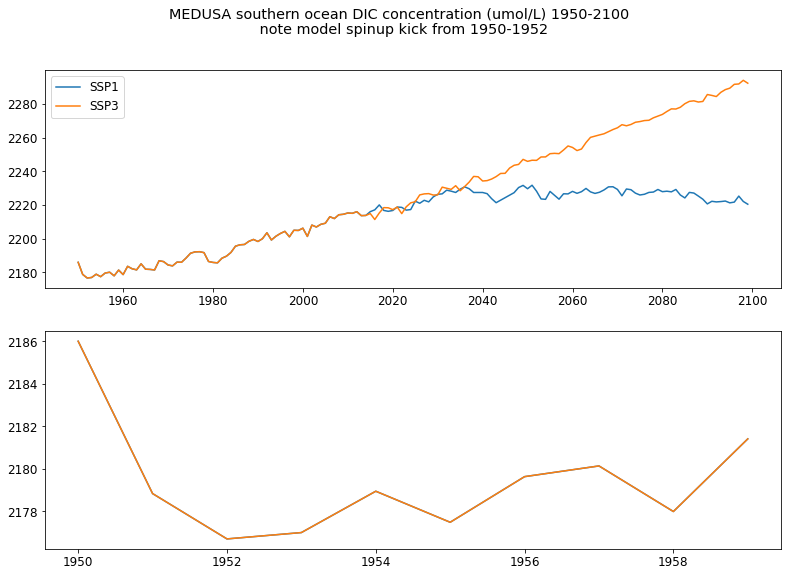

In [18]:
fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(tDIC_1A.year,tDIC_1A, label = 'SSP1')
axs[0].plot(tDIC_1A.year,tDIC_1B, label = 'SSP3')
axs[1].plot(tDIC_1A.year[0:10],tDIC_1A[0:10], label = 'SSP1')
axs[1].plot(tDIC_1A.year[0:10],tDIC_1B[0:10], label = 'SSP3')
plt.suptitle('MEDUSA southern ocean DIC concentration (umol/L) 1950-2100 \n note model spinup kick from 1950-1952')
axs[0].legend(loc = 'best')

# scratch for verifying the SST calculation

In [19]:
def get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False):
    
    
    tdra = np.arange(2050,2400,0.25) * 1e-3
    ttara = np.zeros_like(tdra)
    ttara[:] = ALK * 1e-3
    
    tsra = np.zeros_like(tdra)
    ttera = np.zeros_like(tdra)
    
    tsra[:] = S
    ttera[:] = T
    
    tsra_psu = np.ravel(tsra) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(ttera)
    tdepth = np.zeros_like(ttera)
    tdepth[:] = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)
    
    if verbose:
        print(ttera_is[0])
        print(tsra_psu[0])

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    
    nearest_pco2 = np.min(np.abs(pco2-t_pCO2))
    ind_closest = (np.where((np.abs(pco2-t_pCO2)) == nearest_pco2 ))
    if verbose:
        print(f'DIC is: {tdra[ind_closest]*1e3}')
        print(t_pCO2)
        print(pco2[ind_closest])
        
    tDIC = tdra[ind_closest]*1e3
    tDIC = tDIC[0]
        
    return tDIC, BetaD
 
tDIC = get_DIC_from_pCO2(30,2, 800, ALK = 2349.51722732)

def get_SST_effect(S,T, delT, t_pCO2, ALK = 2349.51722732, verbose = False):

    DIC1 = get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False)
    tpCO2_2 = t_pCO2*0.04*delT+ t_pCO2
    DIC2 = get_DIC_from_pCO2(S,T,tpCO2_2, ALK = 2349.51722732, verbose = False)
    ## change in DIC due to increase in SST is negative
    diff = DIC1-DIC2
    
    return diff, DIC1, DIC2


td = xr.open_dataset('./data/cchem_averages_scen_1B.nc')


def get_revelle(DIC_mean, TA_mean, T_mean, S_mean):
    

    votemper = T_mean
    vosaline = S_mean
    
    tdra = (DIC_mean * 1e-3) #DIC, convert umol/L to mol/m3 (1000 L/m3)
    ttara = (TA_mean * 1e-3) #Alkalinity, convert umol/L to mol/m3 (1000 L/m3)
    tsra = (vosaline) #salt
    tsra_psu = (vosaline) *35/35.16504 #g/kg to psu (salt)
    ttera = (votemper)

    tdepth = np.zeros_like(ttera)
    tdepth = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)


    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pco2, BetaD

alk = td.ALK_glodap[0].values
pco2, BetaD = get_revelle(td.DIC_glodap[0].values, td.ALK_glodap[0].values,\
                          td.T_ts[0].values, td.S_ts[0].values)
tDIC = td.DIC_glodap[0].values
tTA = td.ALK_glodap[0].values
tT = td.T_ts[0].values
tS = td.S_ts[0].values
tpco2 = (pco2[0])
tR = (BetaD[0])



In [20]:
tDIC = td.DIC_glodap[0].values
tTA = td.ALK_glodap[0].values
tT = td.T_ts[0].values
tS = td.S_ts[0].values
tpco2 = (pco2[0])
tR = (BetaD[0])



def get_SST_effect_Rfact(R, DIC, pCO2, sst_delta):
    
    dpCO2 = 0.04*pCO2*sst_delta
    delDIC = (DIC/pCO2) * dpCO2/R
    
    #for a positive increase in sst, negative DIC
    delDIC = -1 *delDIC
    return delDIC
    
    

def get_SST_effect(S,T, delT, t_pCO2, ALK = 2349.51722732, verbose = False):

    DIC1, BetaD = get_DIC_from_pCO2(S,T, t_pCO2, ALK = ALK, verbose = False)
    tpCO2_2 = t_pCO2*0.04*delT+ t_pCO2
    DIC2, BetaD = get_DIC_from_pCO2(S,T,tpCO2_2, ALK = ALK, verbose = False)
    print(ALK)
    ## change in DIC due to increase in SST is negative
    print(DIC1)
    print(DIC2)
    diff = DIC1-DIC2

    
    return diff, DIC1, DIC2


delT = 2
tDIC = 2100
tpco2 = 336
tR = 12.21043501
tS = 32
tT = 10


delDIC = get_SST_effect_Rfact(tR, tDIC, tpco2, delT)
print(delDIC)
diff, DIC1, DIC2,  = get_SST_effect(tS,tT, delT, tpco2, ALK = 2300, verbose = False)
print(DIC1, DIC2, diff)

-13.75872357228983
2300
2101.5
2114.5
2101.5 2114.5 -13.0


In [21]:
ttera_is = 10
tsra_psu = 32
ttara = 2300*1e-3
tdra = 2100*1e-3
tzero = 0
tpressure = 1
tdepth = 0


response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup


print(pco2)
print(BetaD)


ttera_is = 12
tsra_psu = 32
ttara = 2300*1e-3
tdra2 = 2085*1e-3
tzero = 0
tpressure = 1
tdepth = 0


response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra2, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup


print(pco2)

[336.99147932]
[12.21043501]
[336.59542646]


# print out BGC inputs from medusa and observations

In [22]:
w = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-MEDUSA.nc')
print('MEDUSA')
print()
print('1950-2000')
tl = list(w.data_vars)
for l in tl:    
    vall = w[l].loc[{'period':'1950-2000', 'season':'FY', 'scenario': 'ssp1' }].values
    vall3 = w[l].loc[{'period':'1950-2000', 'season':'FY', 'scenario': 'ssp3' }].values
    print(f'{l}, ssp1 {vall}, ssp3 {vall3}')

print()
print('2000-2050')
for l in tl:    
    vall = w[l].loc[{'period':'2000-2050', 'season':'FY', 'scenario': 'ssp1' }].values
    vall3 = w[l].loc[{'period':'2000-2050', 'season':'FY', 'scenario': 'ssp3' }].values
    print(f'{l}, ssp1 {vall}, ssp3 {vall3}')
    
print()
print('2050-2100')
for l in tl:    
    vall = w[l].loc[{'period':'2050-2100', 'season':'FY', 'scenario': 'ssp1' }].values
    vall3 = w[l].loc[{'period':'2050-2100', 'season':'FY', 'scenario': 'ssp3' }].values
    print(f'{l}, ssp1 {vall}, ssp3 {vall3}')
    
    
w = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-OBS.nc')
print('------')
print('OBS')
print()
print('1950-2000')
for l in tl:    
    vall = w[l].loc[{'period':'1950-2000', 'season':'FY', 'scenario': 'ssp1' }].values
    vall3 = w[l].loc[{'period':'1950-2000', 'season':'FY', 'scenario': 'ssp3' }].values
    print(f'{l}, ssp1 {vall}, ssp3 {vall3}')

print()
print('2000-2050')
for l in tl:    
    vall = w[l].loc[{'period':'2000-2050', 'season':'FY', 'scenario': 'ssp1' }].values
    vall3 = w[l].loc[{'period':'2000-2050', 'season':'FY', 'scenario': 'ssp3' }].values
    print(f'{l}, ssp1 {vall}, ssp3 {vall3}')
    
print()
print('2050-2100')
for l in tl:    
    vall = w[l].loc[{'period':'2050-2100', 'season':'FY', 'scenario': 'ssp1' }].values
    vall3 = w[l].loc[{'period':'2050-2100', 'season':'FY', 'scenario': 'ssp3' }].values
    print(f'{l}, ssp1 {vall}, ssp3 {vall3}')

MEDUSA

1950-2000
grad_dFedz, ssp1 0.0005369919413721972, ssp3 0.0005369919413721972
grad_dFev, ssp1 0.055318025052473255, ssp3 0.055318025052473255
mu_L, ssp1 0.4382748972235205, ssp3 0.4382748972235205
dmudFe, ssp1 0.59, ssp3 0.59
diatconc, ssp1 0.1361870277889171, ssp3 0.1361870277889171
mn_kg, ssp1 0.065, ssp3 0.065
mn_SST, ssp1 1.8116605089662374, ssp3 1.8116605089662374
mn_Revfact, ssp1 13.658651409553721, ssp3 13.658651409553721
mn_DIC, ssp1 2189.1437477174004, ssp3 2189.1437477174004
mn_TA, ssp1 2354.7178087252873, ssp3 2354.7178087252873
mn_pCO2, ssp1 314.7495608079569, ssp3 314.7495608079569
grad_dDICdz, ssp1 0.22489127148249125, ssp3 0.22489127148249125
grad_DIC_surfdeep, ssp1 96.50302903962745, ssp3 96.50302903962745

2000-2050
grad_dFedz, ssp1 0.0005426996296534286, ssp3 0.0005459302546715388
grad_dFev, ssp1 0.05849911344861808, ssp3 0.05771978957329153
mu_L, ssp1 0.4382748972235205, ssp3 0.4382748972235205
dmudFe, ssp1 0.59, ssp3 0.59
diatconc, ssp1 0.1339437105769195, ss

## print out output of BOE calculation

In [23]:
output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA_conc.nc'
w = xr.open_dataset(output_str)

pers = ['1950-2000', '2000-2050', '2050-2100']
scens = ['ssp1','ssp3']
forcs = ['ozone','ghg']
quants = ['CO2_SST','CO2_MLD_phys_chem',\
        'CO2_OT_phys_chem','CO2_MLD_bio','CO2_OT_bio']

print('MEDUSA')
for s in range(0,2):
    scen = scens[s]
    for p in range(0,3):
        per = pers[p]
        for f in range(0,2):
            forc = forcs[f]
            for q in range(0,5):
                quant = quants[q]

                
                print(f'{scen}--{per}--{forc}--{quant}')
                trend = (w['trend'].loc[{'period':per, 'season':'FY', 'scenario': scen,\
                'forcing' : forc, 'quantity' : quant}].values)
                sig = (w['sig'].loc[{'period':per, 'season':'FY', 'scenario': scen,\
                'forcing' : forc, 'quantity' : quant}].values)
                print(f'-----TREND: {trend}, SIG {sig}')
            print()
# print(w['trend'].loc[{'period':'1950-2000', 'season':'FY', 'scenario': 'ssp1',\
#             'forcing' : 'ghg', 'quantity' : 'CO2_tot'}].values)

MEDUSA
ssp1--1950-2000--ozone--CO2_SST
-----TREND: -1.1522212651418124, SIG 1.0
ssp1--1950-2000--ozone--CO2_MLD_phys_chem
-----TREND: 2.4021655109306757, SIG 1.0
ssp1--1950-2000--ozone--CO2_OT_phys_chem
-----TREND: 2.8605312580618176, SIG 1.0
ssp1--1950-2000--ozone--CO2_MLD_bio
-----TREND: -0.036888642595870616, SIG 1.0
ssp1--1950-2000--ozone--CO2_OT_bio
-----TREND: -0.010545495681363402, SIG 1.0

ssp1--1950-2000--ghg--CO2_SST
-----TREND: 0.2411501069848718, SIG 0.0
ssp1--1950-2000--ghg--CO2_MLD_phys_chem
-----TREND: -0.719933821677143, SIG 1.0
ssp1--1950-2000--ghg--CO2_OT_phys_chem
-----TREND: -0.33773373799337403, SIG 0.0
ssp1--1950-2000--ghg--CO2_MLD_bio
-----TREND: 0.011055600173960619, SIG 1.0
ssp1--1950-2000--ghg--CO2_OT_bio
-----TREND: 0.0012450728043688717, SIG 0.0

ssp1--2000-2050--ozone--CO2_SST
-----TREND: 2.5158645121432635, SIG 1.0
ssp1--2000-2050--ozone--CO2_MLD_phys_chem
-----TREND: -0.8688347467790716, SIG 0.0
ssp1--2000-2050--ozone--CO2_OT_phys_chem
-----TREND: 0.08030

In [24]:
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS_conc.nc'
w = xr.open_dataset(output_str)

pers = ['1950-2000', '2000-2050', '2050-2100']
scens = ['ssp1','ssp3']
forcs = ['ozone','ghg']
quants = ['CO2_SST','CO2_MLD_phys_chem',\
        'CO2_OT_phys_chem','CO2_MLD_bio','CO2_OT_bio']

print('OBS')
for s in range(0,2):
    scen = scens[s]
    for p in range(0,3):
        per = pers[p]
        for f in range(0,2):
            forc = forcs[f]
            for q in range(0,5):
                quant = quants[q]

                
                print(f'{scen}--{per}--{forc}--{quant}')
                trend = (w['trend'].loc[{'period':per, 'season':'FY', 'scenario': scen,\
                'forcing' : forc, 'quantity' : quant}].values)
                sig = (w['sig'].loc[{'period':per, 'season':'FY', 'scenario': scen,\
                'forcing' : forc, 'quantity' : quant}].values)
                print(f'-----TREND: {trend}, SIG {sig}')
            print()
# print(w['trend'].loc[{'period':'1950-2000', 'season':'FY', 'scenario': 'ssp1',\
#             'forcing' : 'ghg', 'quantity' : 'CO2_tot'}].values)

OBS
ssp1--1950-2000--ozone--CO2_SST
-----TREND: -1.18974227094867, SIG 1.0
ssp1--1950-2000--ozone--CO2_MLD_phys_chem
-----TREND: 4.336163109973697, SIG 1.0
ssp1--1950-2000--ozone--CO2_OT_phys_chem
-----TREND: 4.252433195897485, SIG 1.0
ssp1--1950-2000--ozone--CO2_MLD_bio
-----TREND: -0.42500762662928576, SIG 1.0
ssp1--1950-2000--ozone--CO2_OT_bio
-----TREND: -0.506014067611019, SIG 1.0

ssp1--1950-2000--ghg--CO2_SST
-----TREND: 0.24900293424838357, SIG 0.0
ssp1--1950-2000--ghg--CO2_MLD_phys_chem
-----TREND: -1.2995567811517466, SIG 1.0
ssp1--1950-2000--ghg--CO2_OT_phys_chem
-----TREND: -0.5020711291897131, SIG 0.0
ssp1--1950-2000--ghg--CO2_MLD_bio
-----TREND: 0.12737563814352185, SIG 1.0
ssp1--1950-2000--ghg--CO2_OT_bio
-----TREND: 0.05974345571294161, SIG 0.0

ssp1--2000-2050--ozone--CO2_SST
-----TREND: 2.5346964267215424, SIG 1.0
ssp1--2000-2050--ozone--CO2_MLD_phys_chem
-----TREND: -1.7736302889113662, SIG 0.0
ssp1--2000-2050--ozone--CO2_OT_phys_chem
-----TREND: 0.1355880179074586, 